In [29]:
%pip install opencv-python scikit-learn matplotlib Pillow tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2 # OpenCV for image processing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For augmentation
import matplotlib.pyplot as plt
from PIL import Image # Pillow for robust image opening
import shutil # For organizing files if needed
print("Libraries imported.")

Libraries imported.


In [2]:
BASE_DATA_DIR = "cnn_image_dataset" # Folder containing 'cyclone_visible' and 'no_cyclone_visible'
CATEGORIES = ["cyclone_visible", "no_cyclone_visible"]
IMG_HEIGHT, IMG_WIDTH = 224, 224 # Target image size for your CNN
print(f"Base data directory: {os.path.abspath(BASE_DATA_DIR)}")
print(f"Categories: {CATEGORIES}")
print(f"Target image size: {IMG_HEIGHT}x{IMG_WIDTH}")

Base data directory: d:\AI Model\cnn_image_dataset
Categories: ['cyclone_visible', 'no_cyclone_visible']
Target image size: 224x224


In [3]:
def load_and_preprocess_images_from_folder(base_dir, categories, img_height, img_width):
    data = []
    labels = []
    
    for category_index, category in enumerate(categories):
        path = os.path.join(base_dir, category)
        if not os.path.isdir(path):
            print(f"Warning: Directory not found - {path}")
            continue
        
        print(f"Loading images from: {path} (Label: {category_index})")
        image_count = 0
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                # Use Pillow to open image for robustness, then convert to OpenCV format if needed
                pil_img = Image.open(img_path).convert('RGB') # Ensure 3 channels (RGB)
                pil_img = pil_img.resize((img_width, img_height))
                
                img_array = np.array(pil_img) # Convert PIL image to numpy array
                
                if img_array.shape != (img_height, img_width, 3):
                    print(f"Warning: Image {img_name} has unexpected shape {img_array.shape}. Skipping.")
                    continue
                    
                data.append(img_array)
                labels.append(category_index) # 0 for cyclone_visible, 1 for no_cyclone_visible
                image_count += 1
            except Exception as e:
                print(f"Error loading or processing image {img_path}: {e}")
        print(f"Loaded {image_count} images for category '{category}'.")
        
    if not data:
        print("Error: No data loaded. Check paths and image files.")
        return None, None
    # Normalize pixel values to [0, 1]
    data = np.array(data, dtype="float32") / 255.0
    labels = np.array(labels)
    
    return data, labels
    print("Image loading and preprocessing function defined.")


--- Loading dataset ---
Loading images from: cnn_image_dataset\cyclone_visible (Label: 0)
Loaded 9 images for category 'cyclone_visible'.
Loading images from: cnn_image_dataset\no_cyclone_visible (Label: 1)
Loaded 7 images for category 'no_cyclone_visible'.

Dataset loaded successfully!
Total images loaded: 16
Shape of image data (X): (16, 224, 224, 3)
Shape of labels (y): (16,)
Unique labels: (array([0, 1]), array([9, 7]))


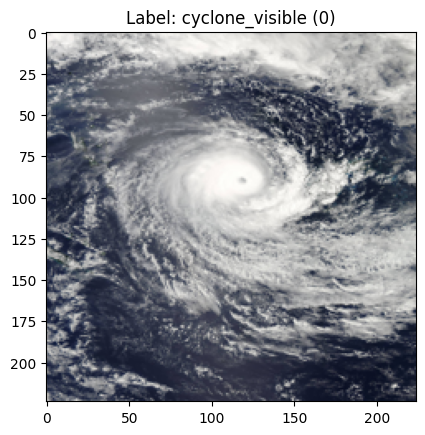

In [4]:
print("\n--- Loading dataset ---")
    # Ensure your BASE_DATA_DIR points to the correct location relative to this notebook
if not os.path.exists(BASE_DATA_DIR):
    print(f"ERROR: The directory '{BASE_DATA_DIR}' does not exist in the current working directory ({os.getcwd()}).")
    print("Please create it and place your 'cyclone_visible' and 'no_cyclone_visible' image folders inside.")
else:
    X, y = load_and_preprocess_images_from_folder(BASE_DATA_DIR, CATEGORIES, IMG_HEIGHT, IMG_WIDTH)
    if X is not None and y is not None and len(X) > 0:
        print(f"\nDataset loaded successfully!")
        print(f"Total images loaded: {len(X)}")
        print(f"Shape of image data (X): {X.shape}") # Should be (num_images, IMG_HEIGHT, IMG_WIDTH, 3)
        print(f"Shape of labels (y): {y.shape}")
        print(f"Unique labels: {np.unique(y, return_counts=True)}")
        # Optional: Display a sample image
        plt.imshow(X[0])
        plt.title(f"Label: {CATEGORIES[y[0]]} ({y[0]})")
        plt.show()
    else:
        print("Failed to load data. Please check the previous output for errors.")

In [14]:
if 'X' in locals() and X is not None and len(X) > 0:
    print("\n--- Splitting dataset ---")
    # First split: Training and (Validation + Test)
    # Ensure you have enough data for a meaningful split (e.g., at least 10-20 images per class after splitting)
    if len(X) < 20: # Arbitrary small number, adjust as needed
        print("Warning: Dataset is very small. Splitting might result in tiny sets.")
        # For very small datasets, consider just train/val or using k-fold cross-validation during training
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_test, y_test = X_val, y_val # Use validation set as test set if too small
        print("Using validation set as test set due to small dataset size.")
    else:
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # 70% train, 30% temp
        # Second split: Validation and Test from the temporary set
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # Split temp 50/50 -> 15% val, 15% test
    print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
    print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
    print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
else:
    print("Skipping data split as data was not loaded.")


--- Splitting dataset ---
Using validation set as test set due to small dataset size.
Training data shape: (12, 224, 224, 3), Training labels shape: (12,)
Validation data shape: (4, 224, 224, 3), Validation labels shape: (4,)
Test data shape: (4, 224, 224, 3), Test labels shape: (4,)


In [21]:
if 'X_train' in locals() and len(X_train) > 0:
        print("\n--- Setting up Data Augmentation (Keras ImageDataGenerator) ---")
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        datagen.fit(X_train)
        print("ImageDataGenerator configured. It will be used during model.fit().")
        print("Labels should be one-hot encoded if using categorical_crossentropy loss.")
else:
    print("Skipping data augmentation setup as training data is not available.")



--- Setting up Data Augmentation (Keras ImageDataGenerator) ---
ImageDataGenerator configured. It will be used during model.fit().
Labels should be one-hot encoded if using categorical_crossentropy loss.


In [22]:
np.savez_compressed('cnn_processed_data.npz', X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, categories=CATEGORIES)
print("\nPreprocessed data (X_train, y_train, etc.) can be saved if needed.")
print("Data can be loaded using the following code:")
print("\n--- CNN Data Preparation Notebook Complete ---")
print("Next steps: Proceed to Phase B - CNN Model Development & Training in a new notebook or script.")
    


Preprocessed data (X_train, y_train, etc.) can be saved if needed.
Data can be loaded using the following code:

--- CNN Data Preparation Notebook Complete ---
Next steps: Proceed to Phase B - CNN Model Development & Training in a new notebook or script.
